# School Supplies - Topic Modelling

Topic models have been designed specifically for the purpose of extracting various distinguishing concepts or topics from a large corpus having various types of documents where each document talks about one or more concepts. These concepts can be anything from thoughts, opinions, facts, outlooks, statements and so on. The main aim of topic modeling is to use mathematical and statistical techniques to discover hidden and latent semantic structures in a corpus. Topic modeling involves extracting features from document terms and using mathematical structures and frameworks like matrix factorization and SVD to generate clusters or groups of terms which are distinguishable from each other and these cluster of words form topics or concepts. These concepts can be used to interpret the main themes of a corpus and also make semantic connections amongst words which co-occur together frequently in various documents. There are various frameworks and algorithms to build topic models. The most popular ones include

 - Latent Semantic Indexing (LSI)
 - Latent Dirichlet Allocation (LDA)
 - Non-negative Matrix Factorization (NNMF)

The last technique we will look at is non-negative matrix factorization (**NNMF**), which is another matrix decomposition technique similar to SVD but operates on non-negative matrices and works well for multivariate data. NNMF can be formally defined as, given a non-negative matrix V, the objective is to find two non-negative matrix factors, W and H such that when they are multiplied, they can approximately reconstruct V. 

  >V≈WH

such that all three matrices are non-negative.

To get to this approximation, we usually use a cost function like the Euclidean distance or L2 norm between two matrices or the Frobenius norm which is a slight modification of the L2 norm.

This implementation is available in the NMF class in the scikit-learn decomposition module which we will be using in the section.

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import gensim
import nltk

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support

from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer

from gensim.models.word2vec import Word2Vec
from nltk import word_tokenize
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /Users/amy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
np.set_printoptions(precision=2, linewidth=80)

## Load and View Dataset

In [3]:
df = pd.read_csv('cleaned_text_school_supplies.csv')

In [4]:
df.isnull().sum()

customer_ID        0
product_ID         0
rating             0
review_text        0
rating_class       0
date_time          0
normalized_text    1
tokens             0
dtype: int64

In [5]:
df = df.dropna(axis=0)

In [6]:
# Converting categorical to numerical 
df['rating_class'] = df['rating_class'].replace({'good': 1,'neutral': 0,'bad':0 })
# Converting categorical to numerical 
df['rating_class'] = df['rating_class'].replace({1: 'good',0 :'bad' })

In [7]:
df.head(2)

,customer_ID,product_ID,rating,review_text,rating_class,date_time,normalized_text,tokens
0,0136039847,A2MVR1VMDPMNGS,1.0,I honestly believe that giving this merchant o...,bad,2014-03-03,honestly believe give merchant one star favor ...,"['honestly', 'believe', 'give', 'merchant', 'o..."
1,0439504422,ASTJ36CFZRN3O,5.0,This is a standard size folder that fits stand...,good,2012-09-18,standard size folder fit standard paper 5x11 f...,"['standard', 'size', 'folder', 'fit', 'standar..."


## Prepare Train Test Split

In [8]:
df_train = df[:8000]
df_test = df[8000:]

In [9]:
text_reviews = df['normalized_text'].values
train_text_reviews = text_reviews [:8000]
test_text_reviews = text_reviews [8000:]

sentiments = df['rating_class'].values
train_sentiments = sentiments[:8000]
test_sentiments = sentiments[8000:]

## Extract features from positive and negative reviews

The first step in this analysis is to combine all our normalized train and test reviews and separate out these reviews into positive and negative sentiment reviews. Once we do this, we will extract features from these two datasets using the TF-IDF feature vectorizer. The following snippet helps us achieve this.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Take all normalized reviews and get tf-idf features for only positive reviews

positive_reviews = [review for review, sentiment in zip(text_reviews, sentiments) if sentiment == 'good']
#### or you can use the method below #####
# positive_reviews = df[df.rating_class == 'good']['normalized_text'].values.tolist()

ptvf = TfidfVectorizer(use_idf=True, min_df=0.02, max_df=0.75, ngram_range=(1, 2), sublinear_tf=True)
ptvf_features = ptvf.fit_transform(positive_reviews)

In [11]:
# get tf-idf features for only negative reviews
negative_reviews = [review for review, sentiment in zip(text_reviews, sentiments) if sentiment == 'bad']
ntvf = TfidfVectorizer(use_idf=True, min_df=0.02, max_df=0.75, ngram_range=(1, 2), sublinear_tf=True)
ntvf_features = ntvf.fit_transform(negative_reviews)

In [12]:
# view feature set dimensions
print(ptvf_features.shape, ntvf_features.shape)

(8318, 261) (2517, 304)


From the preceding output dimensions, you can see that we have filtered out a lot of the features we used previously when building our classification models by making **min_df** to be 0.02 and **max_df** to be 0.75. This is to speed up the topic modeling process and remove features that either occur too much or too rarely. Let’s now import the necessary dependencies for the topic modeling process.

## Topic Modeling on Reviews

pyLDAvis is a Python library for interactive topic model visualization. 

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The visualization is intended to be used within an IPython notebook but can also be saved to a stand-alone HTML file for easy sharing.

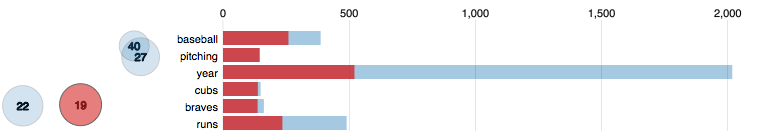

In [13]:
from IPython.display import Image
Image(filename = '/Users/amy/00_Springboard/14_Capstone_Project_2/pyLDAvis.png')

In [21]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import NMF
import topic_model_utils as tmu

pyLDAvis.enable_notebook()
total_topics = 10

## Positive reviews / Display and visualize topics 

In [23]:
#import pyLDAvis_prepare as ps

In [16]:
# build topic model on positive sentiment review features

pos_nmf = NMF(n_components=total_topics, solver='cd', max_iter=500,
               random_state=42, alpha=.1, l1_ratio=.85)
pos_nmf.fit(ptvf_features)      


NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.85, max_iter=500,
  n_components=10, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [17]:
# extract features and component weights
pos_feature_names = np.array(ptvf.get_feature_names())
#pos_feature_names = (x for x in pos_feature_names if len(x) > 0)

In [18]:
pos_weights = pos_nmf.components_

In [19]:
# extract and display topics and their components

pos_feature_names = np.array(ptvf.get_feature_names())

feature_idxs = np.argsort(-pos_weights)[:, :15]

topics = [pos_feature_names[idx] for idx in feature_idxs]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print(', '.join(topic))
    print()
    


Topic #1:
not, one, like, get, make, look, buy, need, time, little, find, really, perfect, go, would

Topic #2:
work, well, work well, work great, fine, perfectly, printer, no, problem, use, purchase, ink, need, far, print

Topic #3:
paper, color, print, printer, use, nice, sheet, quality, like, ink, weight, project, beautiful, write, make

Topic #4:
love, calendar, gift, year, daughter, perfect, picture, buy, friend, fun, beautiful, get, son, cute, give

Topic #5:
pen, write, ink, fine, point, black, line, use, feel, pocket, nice, set, ever, like, hand

Topic #6:
use, easy, cable, easy use, cord, tie, velcro, keep, label, organize, wire, wrap, computer, make, handy

Topic #7:
product, great product, excellent, order, exactly, arrive, thank, no, need, happy, come, time, amazon, fast, receive

Topic #8:
good, quality, price, good quality, value, nice, buy, high, item, great price, ever, purchase, expect, deal, well

Topic #9:
recommend, would, highly, highly recommend, would recommend, 

In the positive reviews, some of topics are related with printer, print, ink, paper, pen  and computer. This shows the strong side of the company.

In [100]:
#pyLDAvis.sklearn.prepare(pos_nmf, ptvf_features, ptvf, R=15)

## Negative reviews / Display and visualize topics

In [101]:
# build topic model on negative sentiment review features
neg_nmf = NMF(n_components=total_topics, solver='cd', max_iter=500,
              random_state=42, alpha=.1, l1_ratio=.85)
neg_nmf.fit(ntvf_features)      
# extract features and component weights
neg_feature_names = ntvf.get_feature_names()
neg_weights = neg_nmf.components_
# extract and display topics and their components
neg_feature_names = np.array(ntvf.get_feature_names())
feature_idxs = np.argsort(-neg_weights)[:, :15]
topics = [neg_feature_names[idx] for idx in feature_idxs]
for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print(', '.join(topic))
    print()

Topic #1:
use, would, get, one, buy, make, go, come, even, time, great, think, try, really, could

Topic #2:
money, waste, waste money, not waste, buy, time, not buy, product, no, clean, not worth, save, worth, not even, spend

Topic #3:
work, not work, well, work well, ok, stick, printer, wall, much, cartridge, surface, time, would not, product, use

Topic #4:
look, like, look like, picture, not like, nice, something, cheap, bag, expect, plastic, feel, job, item, lot

Topic #5:
pen, ink, write, dry, point, nice, buy, line, letter, cartridge, pack, every, feel, set, ever

Topic #6:
product, item, receive, order, send, amazon, return, picture, description, box, arrive, seller, no, company, package

Topic #7:
good, not good, product, price, want, deal, job, little, bad, idea, though, pretty, bit, quality, enough

Topic #8:
paper, print, thin, sheet, printer, color, ink, write, page, side, letter, use, binder, no, nothing

Topic #9:
quality, poor, cheap, expect, price, material, high, mak

In [102]:
pyLDAvis.sklearn.prepare(neg_nmf, ntvf_features, ntvf, R=15)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.050642  0.115844       1        1  42.106542
5     -0.025477  0.208608       2        1  14.248745
3      0.132511 -0.121816       3        1   7.714613
2     -0.160862  0.104022       4        1   7.269737
9      0.106101  0.059860       5        1   5.699027
8      0.246790 -0.165963       6        1   4.935801
6      0.243924  0.019120       7        1   4.870375
1     -0.075059  0.211381       8        1   4.795444
7     -0.205570 -0.227133       9        1   4.524467
4     -0.211716 -0.203924      10        1   3.835249, topic_info=    Category        Freq         Term       Total  loglift  logprob
93   Default  251.000000         good  251.000000  15.0000  15.0000
186  Default  219.000000        paper  219.000000  14.0000  14.0000
296  Default  224.000000         work  224.000000  13.0000  13.0000
211  Default  194.000000      quality  194.000000  12.0000  12.0000
189  Default  155.000000          pen  155.000000  11.0000  11.0000
135  Default  188.000000         look  188.000000  10.0000  10.0000
251  Default  155.000000        small  155.000000   9.0000   9.0000
131  Default  174.000000         like  174.000000   8.0000   8.0000
164  Default  122.000000     not good  122.000000   7.0000   7.0000
170  Default  127.000000     not work  127.000000   6.0000   6.0000
148  Default  105.000000        money  105.000000   5.0000   5.0000
286  Default   92.000000        waste   92.000000   4.0000   4.0000
198  Default   89.000000         poor   89.000000   3.0000   3.0000
287  Default   80.000000  waste money   80.000000   2.0000   2.0000
84   Default   83.000000          fit   83.000000   1.0000   1.0000
3     Topic1    9.065364       almost    9.065364   0.8650  -6.0524
233   Topic1    9.130870       school    9.130870   0.8650  -6.0452
150   Topic1    9.238612         move    9.238612   0.8650  -6.0335
34    Topic1   17.059901         card   17.059901   0.8650  -5.4201
210   Topic1   21.827409          put   21.827409   0.8650  -5.1737
193   Topic1   23.139896        piece   23.139896   0.8650  -5.1153
303   Topic1   21.711274         year   21.711274   0.8650  -5.1790
166   Topic1    8.492188   not really    8.492188   0.8650  -6.1177
128   Topic1    8.220847          let    8.220847   0.8650  -6.1502
146   Topic1    8.599070         mean    8.599070   0.8650  -6.1052
147   Topic1    9.144983        metal    9.144983   0.8650  -6.0437
152   Topic1    6.505502         must    6.505502   0.8650  -6.3842
156   Topic1    7.423868         next    7.423868   0.8650  -6.2522
207   Topic1    9.152916         pull    9.152916   0.8650  -6.0428
178   Topic1   15.472795          old   15.472795   0.8650  -5.5178
..       ...         ...          ...         ...      ...      ...
248   Topic9    6.154898         side   19.315208   1.9520  -4.2089
185   Topic9    6.685696         page   21.471671   1.9289  -4.1262
19    Topic9    5.510054       binder   21.919235   1.7149  -4.3196
290   Topic9    2.665646       weight   11.054640   1.6733  -5.0457
230   Topic9    2.515481          run   10.492221   1.6675  -5.1037
292   Topic9    2.944552        white   12.965190   1.6134  -4.9462
42    Topic9    9.327732        color   42.732112   1.5737  -3.7932
173   Topic9    3.483264      nothing   18.147002   1.4451  -4.7782
26    Topic9    2.438063        brand   13.150967   1.4104  -5.1350
301   Topic9    8.300265        write   61.256446   1.0969  -3.9099
113   Topic9    9.225691          ink   74.366627   1.0087  -3.8042
282   Topic9    5.592652          use   83.635439   0.3907  -4.3047
158   Topic9    3.768620           no   63.841443   0.2660  -4.6995
189  Topic10  155.970532          pen  155.970532   3.2609  -0.8112
301  Topic10   45.595453        write   61.256446   2.9657  -2.0411
113  Topic10   51.657303          ink   74.366627   2.8966  -1.9163
197  Topic10   10.046525        point   18.13